In [1]:
import os
import pickle
from pathlib import Path
import re

import itertools
import numpy as np
import pandas as pd

from collections import Counter
from functools import reduce

import spacy
import nltk
from nltk.stem import PorterStemmer
from gensim.corpora import Dictionary
from nltk.tokenize import sent_tokenize, word_tokenize, MWETokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from spmf import Spmf
from liwc import Liwc

from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgbm
from sklearn.svm import SVC

import optuna

from ml_utils import *

from IPython.display import clear_output

In [1]:
pip freeze > "requirements.txt"

Note: you may need to restart the kernel to use updated packages.


In [2]:
TRAIN_SIZE = 0.80
ts = f"{TRAIN_SIZE:.2f}"
RANDOM_STATE = 52

DF_NAMES = ["essays", "mbti_onehot"]
DF_NAME = DF_NAMES[0]

data_dir = os.path.join(Path.cwd().parent, 'datasets')

dataset_dir = os.path.join(data_dir, DF_NAME)
nosep_dir = os.path.join(data_dir, "pattern_mining")
nosep_files_dir = os.path.join(nosep_dir, 'files')
pattern_dir = os.path.join(nosep_dir, 'patterns')
stats_dir = os.path.join(dataset_dir, f"stats_TRAIN_SIZE-{ts.split('.')[1]}%")

patterns_combined_dir = os.path.join(dataset_dir, "patterns_combined")

# Model training

Save metrics about performance of each model on every dataset

In [ ]:
df_text = pd.read_csv(os.path.join(dataset_dir, DF_NAME+".csv"), index_col=0)
char_cols = [x for x in df_text.columns if x not in ['author', 'text']]
Y = df_text[char_cols].astype(str).agg(''.join, axis=1)
df_text_train, df_text_test = train_test_split(df_text, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)
train_ids, test_ids = df_text_train.author, df_text_test.author

n_components = 100

for model_name, objective in {

    "LightGBM": lgbm_objective,
    "SVM": svm_objective,
    "LDA": lda_objective,
    "KMeans": kmeans_objective,
    "Naive-Bayes": nb_objective,   
    "Random-forest": rf_objective,
    "Logistic-Regression": logreg_objective,
    
}.items():

    print(f"\n{'-'*15} {model_name} {'-'*15}")

    results = {}

    for stats in [x for x in os.listdir(stats_dir) if 'stats' in x]:

        results_name = " ".join(stats.split("_")[6:])

        stats_df = pd.read_csv(os.path.join(stats_dir, stats), index_col=0).drop('text', axis=1)
        stats_df = stats_df.fillna(0)
        stats_df = stats_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))
#         stats_df['unique_emotional_words'] = stats_df['unique_emotional_words'].apply(len)
        
        print(stats)

        stats_df = stats_df.drop([x for x in stats_df.columns if "dict" in x], axis='columns')
        stats_df = stats_df.rename(columns={'': 'empty'})
        stats_df = stats_df.loc[:, ~stats_df.columns.duplicated()]
        
        ## Dimentionality reduction
        vec_cols = [x for x in stats_df.columns if "VEC" in x]
        
        lsa = TruncatedSVD(n_components=n_components, random_state=RANDOM_STATE)

        lsa_features = pd.DataFrame(lsa.fit_transform(stats_df[vec_cols].values),
                                    index=stats_df.index,
                                    columns=["LSA"+str(i) for i in range(n_components)])
        
        stats_df = stats_df[[x for x in stats_df.columns if "VEC" not in x]]
        stats_df = pd.merge(stats_df, lsa_features, left_index=True, right_index=True, how='outer')
        
        basic_columns = [x for x in stats_df.columns if not any(a[1:] in x for a in char_cols)]
        
        # NO D2V or LSA
#         stats_df = stats_df[[x for x in stats_df.columns if "D2V" not in x and "LSA" not in x]]

         # Only AGDS
#         stats_df = stats_df[[x for x in stats_df.columns if "AGDS" in x or "common" in x or "N_all" in x or x in char_cols]]
        
        scaler = MinMaxScaler((-1, 1))
    
        X = stats_df[[x for x in stats_df.columns if x not in char_cols]]
        X = pd.DataFrame(scaler.fit_transform(X),
                         columns=X.columns, index=X.index)

        X_train = X.loc[train_ids]
        Y_train = stats_df.loc[train_ids, char_cols].astype(int)

        X_test = X.loc[test_ids]
        Y_test = stats_df.loc[test_ids, char_cols].astype(int)

        results[stats] = {}
        
        for cc in char_cols:

            #cc_cols = [x for x in X_train.columns if cc[1:] in x]
            #X_train = X_train[basic_columns + cc_cols]
            #X_test = X_test[basic_columns + cc_cols]

            results[stats][cc] = {}

            print(f'--------- {cc} ---------')
            y_train = Y_train[cc]
            y_test = Y_test[cc]

            #X_val, Xtest, y_val, y_test = train_test_split(X_test, ytest, train_size=0.5, stratify=y_test)

            study = optuna.create_study(direction="maximize", study_name=model_name)
            func = lambda trial: objective(trial, X_train, y_train, X_test, y_test)
            study.optimize(func, n_trials=100)

            results[stats][cc]['f1score'] = study.best_value
            results[stats][cc]['params'] = study.best_params            

    with open(os.path.join(stats_dir, rf'results\results_{model_name}.pickle'), 'wb') as f:
        pickle.dump(results, f)

In [4]:
df_results = print_results_scores(os.path.join(stats_dir, r'results'))
df_results.index = [x.split('.')[0] for x in df_results.index]
df_results  

cEXT      cNEU  \
KMeans_2102102lemma_spaCy                           0.528265  0.512016   
KMeans_2102102no_stop_words_lemma_spaCy             0.530395  0.485653   
KMeans_2102102no_stop_words_spaCy                   0.526269  0.520257   
KMeans_2102102spaCy                                 0.527274  0.503347   
KMeans_2152152spaCy                                 0.529717   0.50124   
LDA_2102102lemma_spaCy                              0.805649  0.801619   
LDA_2102102no_stop_words_lemma_spaCy                0.773227    0.7591   
LDA_2102102no_stop_words_spaCy                      0.791489  0.773235   
LDA_2102102spaCy                                    0.821616  0.821769   
LDA_2152152spaCy                                    0.817772  0.815674   
LightGBM_2102102lemma_spaCy                         0.874321  0.872477   
LightGBM_2102102no_stop_words_lemma_spaCy           0.858146  0.825911   
LightGBM_2102102no_stop_words_spaCy                 0.841576  0.817718   
LightGBM_2102102spaCy                               0.876401  0.872477   
LightGBM_2152152spaCy                               0.870126  0.886645   
Logistic-Regression_2102102lemma_spaCy              0.710252   0.63253   
Logistic-Regression_2102102no_stop_words_lemma_...  0.769616  0.708445   
Logistic-Regression_2102102no_stop_words_spaCy      0.749737  0.748988   
Logistic-Regression_2102102spaCy                    0.731898  0.663543   
Logistic-Regression_2152152spaCy                    0.719103  0.661465   
Naive-Bayes_2102102lemma_spaCy                      0.491846   0.55089   
Naive-Bayes_2102102no_stop_words_lemma_spaCy        0.445319  0.576324   
Naive-Bayes_2102102no_stop_words_spaCy              0.455861  0.508357   
Naive-Bayes_2102102spaCy                            0.466769  0.527924   
Naive-Bayes_2152152spaCy                            0.464837  0.540172   
Random-forest_2102102lemma_spaCy                    0.739757  0.754787   
Random-forest_2102102no_stop_words_lemma_spaCy      0.766124  0.738754   
Random-forest_2102102no_stop_words_spaCy            0.746315  0.704395   
Random-forest_2102102spaCy                          0.769919  0.740801   
Random-forest_2152152spaCy                          0.752209  0.698389   
SVM_2102102lemma_spaCy                               0.85222  0.860264   
SVM_2102102no_stop_words_lemma_spaCy                 0.82188  0.836042   
SVM_2102102no_stop_words_spaCy                      0.860336  0.848187   
SVM_2102102spaCy                                    0.880571   0.86008   
SVM_2152152spaCy                                    0.838057   0.84195   

                                                        cAGR      cCON  \
KMeans_2102102lemma_spaCy                           0.510539  0.505846   
KMeans_2102102no_stop_words_lemma_spaCy             0.496541  0.501943   
KMeans_2102102no_stop_words_spaCy                   0.508607  0.503994   
KMeans_2102102spaCy                                 0.511923  0.513468   
KMeans_2152152spaCy                                 0.514026  0.511362   
LDA_2102102lemma_spaCy                              0.801561  0.805496   
LDA_2102102no_stop_words_lemma_spaCy                0.756933  0.738666   
LDA_2102102no_stop_words_spaCy                      0.756531  0.783235   
LDA_2102102spaCy                                    0.811853  0.836014   
LDA_2152152spaCy                                    0.811853  0.827939   
LightGBM_2102102lemma_spaCy                         0.889725  0.880289   
LightGBM_2102102no_stop_words_lemma_spaCy           0.835534  0.833768   
LightGBM_2102102no_stop_words_spaCy                 0.847544  0.825797   
LightGBM_2102102spaCy                               0.883908  0.886252   
LightGBM_2152152spaCy                               0.879464  0.886439   
Logistic-Regression_2102102lemma_spaCy              0.678693  0.682808   
Logistic-Regression_2102102no_stop_words_lemma_...  0.731869  0.685829   
Logistic-Regression_2102102no_stop_words_spaCy      0.78598

In [5]:
df_results.max()

cEXT    0.880571
cNEU    0.886645
cAGR    0.889725
cCON    0.886439
cOPN    0.927126
dtype: object

Best avg results

In [6]:
df_results.T.mean().sort_values(ascending=False)

LightGBM_2102102spaCy                                   0.889233
LightGBM_2152152spaCy                                   0.888736
LightGBM_2102102lemma_spaCy                             0.881905
SVM_2102102spaCy                                        0.861902
SVM_2102102lemma_spaCy                                  0.860604
SVM_2102102no_stop_words_spaCy                          0.855839
SVM_2152152spaCy                                        0.844906
LightGBM_2102102no_stop_words_lemma_spaCy               0.843139
LightGBM_2102102no_stop_words_spaCy                     0.838167
SVM_2102102no_stop_words_lemma_spaCy                    0.833582
LDA_2102102spaCy                                        0.822622
LDA_2152152spaCy                                        0.817388
LDA_2102102lemma_spaCy                                  0.808447
LDA_2102102no_stop_words_spaCy                          0.782031
Random-forest_2102102spaCy                              0.767819
LDA_2102102no_stop_words_

# Evaluation of best model

In [7]:
results_dir = os.path.join(stats_dir, 'results')

with open(os.path.join(results_dir, 'results_LightGBM.pickle'), 'rb') as f:
    results = pickle.load(f)
    f.close()

df_text = pd.read_csv(os.path.join(dataset_dir, DF_NAME+".csv"), index_col=0)
char_cols = [x for x in df_text.columns if x not in ['author', 'text']]
Y = df_text[char_cols].astype(str).agg(''.join, axis=1)
df_text_train, df_text_test = train_test_split(df_text, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)
train_ids, test_ids = df_text_train.author, df_text_test.author

pattern_features = ['common words count', 'unique common words', 'AGDS common words count', '(N_c_w) / N_all_w) / (N_c / N_all)', 'common patterns count', 'unique patterns', 'AGDS common patterns count', '(N_c_p) / N_all_p) / (N_c / N_all)', 'patterns', 'pattern']
word_features = ['word count', 'unique words', 'average sentence length', 'standard deviation of sentence length', 'emotional words count', 'unique emotional words']

In [8]:
best_csv = 'stats_minlen2_maxlen10_minlen2_maxgap10_minsup2_spaCy.csv'
n_components = 100

df_best = pd.read_csv(os.path.join(stats_dir, best_csv), index_col=0).drop('text', axis=1)
df_best = df_best.fillna(0)
df_best = df_best.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))
# df_best['unique_emotional_words'] = df_best['unique_emotional_words'].apply(len)

df_best = df_best.drop([x for x in df_best.columns if "dict" in x], axis='columns')
df_best = df_best.rename(columns={'': 'empty'})
df_best = df_best.loc[:, ~df_best.columns.duplicated()]

## Dimentionality reduction
vec_cols = [x for x in df_best.columns if "VEC" in x]

lsa = TruncatedSVD(n_components=n_components, random_state=RANDOM_STATE)

lsa_features = pd.DataFrame(lsa.fit_transform(df_best[vec_cols].values),
                            index=df_best.index,
                            columns=["LSA"+str(i) for i in range(n_components)])

df_best = df_best[[x for x in df_best.columns if "VEC" not in x]]
df_best = pd.merge(df_best, lsa_features, left_index=True, right_index=True, how='outer')

# NO D2V or LSA
#         df_best = df_best[[x for x in df_best.columns if "D2V" not in x and "LSA" not in x]]

 # Only AGDS
#         df_best = df_best[[x for x in df_best.columns if "AGDS" in x or "common" in x or "N_all" in x or x in char_cols]]

# scaler = StandardScaler()
scaler = MinMaxScaler((-1, 1))

X = df_best[[x for x in df_best.columns if x not in char_cols]]
X = pd.DataFrame(scaler.fit_transform(X),
                 columns=X.columns, index=X.index)

X_train = X.loc[train_ids]
Y_train = df_best.loc[train_ids, char_cols].astype(int)

X_test = X.loc[test_ids]
Y_test = df_best.loc[test_ids, char_cols].astype(int)

--------- cEXT ---------
[LightGBM] [Warning] seed is set=52, random_state=52 will be ignored. Current value: seed=52
[LightGBM] [Warning] feature_fraction is set=0.7574848626840925, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7574848626840925
[LightGBM] [Warning] bagging_fraction is set=0.9854337328866438, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9854337328866438
[LightGBM] [Warning] lambda_l1 is set=0.7312736578813019, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7312736578813019
[LightGBM] [Warning] lambda_l2 is set=5.958396226284903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.958396226284903
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
              precision    recall  f1-score   support

           0       0.90      0.83      0.86       252
           1       0.83      0.91      0.87       242

    accuracy                           0.87 

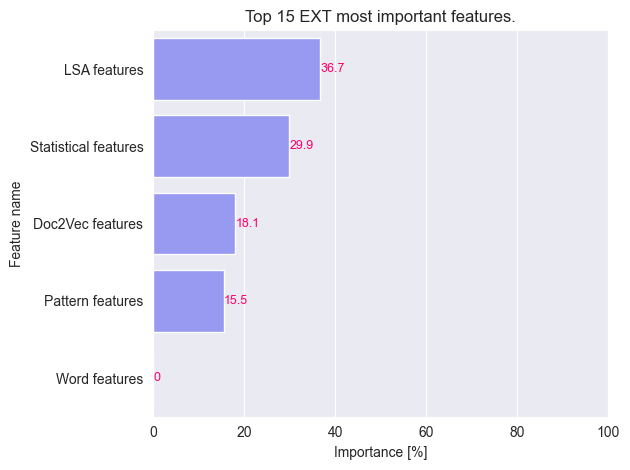

--------- cNEU ---------
[LightGBM] [Warning] seed is set=52, random_state=52 will be ignored. Current value: seed=52
[LightGBM] [Warning] feature_fraction is set=0.8917918960261966, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8917918960261966
[LightGBM] [Warning] bagging_fraction is set=0.9621947038153834, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9621947038153834
[LightGBM] [Warning] lambda_l1 is set=0.24264809144898372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24264809144898372
[LightGBM] [Warning] lambda_l2 is set=1.8203191269805366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8203191269805366
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       243
           1       0.86      0.84      0.85       251

    accuracy                           0

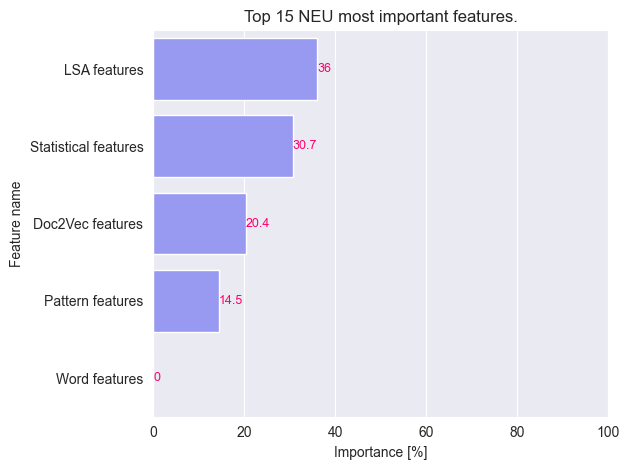

--------- cAGR ---------
[LightGBM] [Warning] seed is set=52, random_state=52 will be ignored. Current value: seed=52
[LightGBM] [Warning] feature_fraction is set=0.5466641930949893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5466641930949893
[LightGBM] [Warning] bagging_fraction is set=0.7482332428555103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7482332428555103
[LightGBM] [Warning] lambda_l1 is set=1.3917761099430577, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3917761099430577
[LightGBM] [Warning] lambda_l2 is set=5.171958336021924, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.171958336021924
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
              precision    recall  f1-score   support

           0       0.94      0.81      0.87       230
           1       0.85      0.95      0.90       264

    accuracy                           0.89 

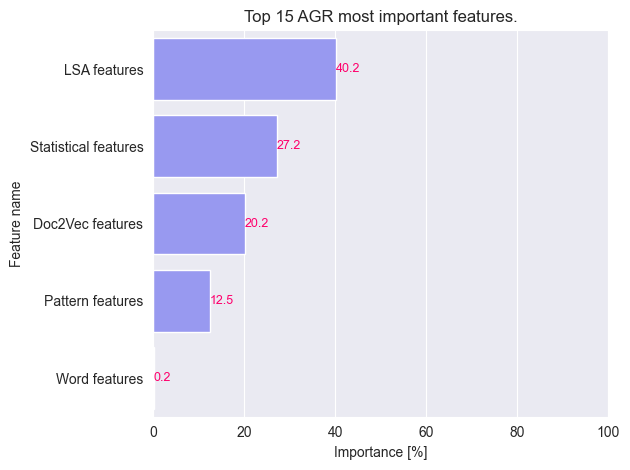

--------- cCON ---------
[LightGBM] [Warning] seed is set=52, random_state=52 will be ignored. Current value: seed=52
[LightGBM] [Warning] feature_fraction is set=0.4858786182341167, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4858786182341167
[LightGBM] [Warning] bagging_fraction is set=0.7573049329112898, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7573049329112898
[LightGBM] [Warning] lambda_l1 is set=1.124238775682886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.124238775682886
[LightGBM] [Warning] lambda_l2 is set=5.021321441191573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.021321441191573
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
              precision    recall  f1-score   support

           0       0.91      0.80      0.86       250
           1       0.82      0.92      0.87       244

    accuracy                           0.86   

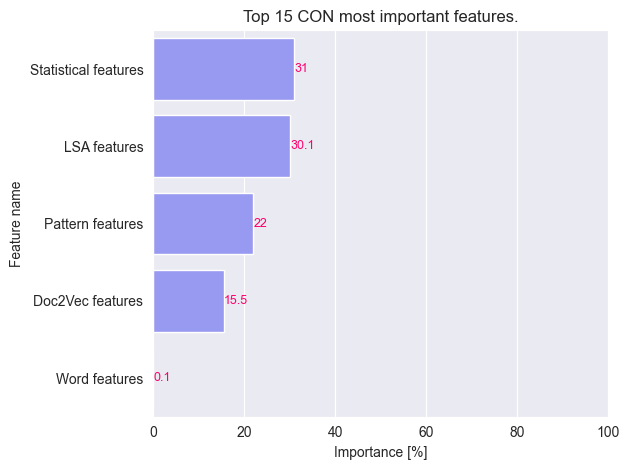

--------- cOPN ---------
[LightGBM] [Warning] seed is set=52, random_state=52 will be ignored. Current value: seed=52
[LightGBM] [Warning] feature_fraction is set=0.8410212727173404, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8410212727173404
[LightGBM] [Warning] bagging_fraction is set=0.6775910712367607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6775910712367607
[LightGBM] [Warning] lambda_l1 is set=1.9714090996965572, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9714090996965572
[LightGBM] [Warning] lambda_l2 is set=6.1397762223324825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.1397762223324825
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       246
           1       0.91      0.91      0.91       248

    accuracy                           0.9

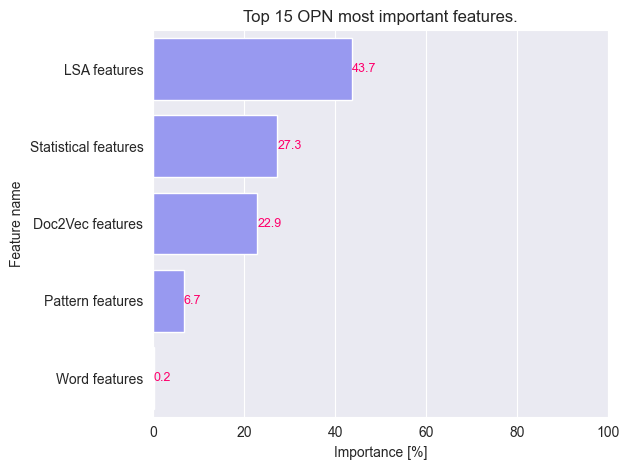

In [10]:
from matplotlib.colors import LinearSegmentedColormap

# Generate colormap through matplotlib
newCmap = LinearSegmentedColormap.from_list("", ['#FF006C', '#898AFF'])

classes = ['r', 'g', 'b']

# set RGB tuple per class
colors = [(255/255, 0, 108/255), (137/255, 138/255, 255/255)]

for cc, v in results[best_csv].items():
    
    print(f'--------- {cc} ---------')
    y_train = Y_train[cc]
    y_test = Y_test[cc]
    
    model = lgbm.LGBMClassifier(objective="binary", **v['params'], random_state=52, seed=52)
    model.fit(
        X_train,
        y_train,
        eval_metric="binary_logloss",
    )
    
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
        
    FI = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    FI.index = [x.replace("_", " ") for x in FI.index]
    FI = FI.rename({
        'CC': 'conjunctions',
        'NNS': 'common plural nouns',
        'neg': 'negative sentiment',
        'len word 6': 'words with more than 6 characters',
    })
    FI = FI / FI.sum() * 100
    FI = FI.round(1)
    
    lsa_sum = FI[[x for x in FI.index if 'LSA' in x]].sum()
    FI['Doc2Vec features'] = FI[[x for x in FI.index if 'D2V' in x]].sum()
    FI = FI[[x for x in FI.index if 'D2V' not in x]]
    FI = FI[[x for x in FI.index if 'LSA' not in x]]
    FI['LSA features'] = lsa_sum
    
    FI['Word features'] = FI[[x for x in FI.index if any(s in x for s in word_features)]].sum()
    FI['Pattern features'] = FI[[x for x in FI.index if any(s in x for s in pattern_features)]].sum()

    FI = FI[[x for x in FI.index if not any(s in x for s in pattern_features)]]
    FI = FI[[x for x in FI.index if not any(s in x for s in pattern_features)]]

    FI['Statistical features'] = FI[[x for x in FI.index if x not in ['Word features', 'Pattern features', 'LSA features', 'Doc2Vec features']]].sum()

    FI = FI[[x for x in FI.index if x in ['Word features', 'Pattern features', 'LSA features', 'Doc2Vec features', 'Statistical features']]]

    n = 15
    visualize_feature_importances(FI, n=n, title=f'Top {n} {cc[1:]} most important features.')
    plt.ylabel("Feature name")
    plt.xlabel("Importance [%]")
    plt.xlim(0, 100)
    plt.tight_layout()
    plt.savefig(f'figures\FeatureImportance_{cc[1:]}.png')
    plt.show()
